**recsys-cluster-loss**

Example of cluster analysis in the context of recommendation systems.
Users who receive recommendations will be grouped based on the individual fairness measure of those recommendations.
The objective is to analyze whether there is any type of injustice of non-obvious user groups, that is, groups that cannot be configured based on some explicit user characteristic (variable) (for example: gender, age, etc.) .

Two methods of grouping will be applied:
1. Hierarchical clustering (tree clustering - dendrogram)
2. Non-hierarchical grouping by breakdown (grouping by k-Means)

In this file we are analyzing the possible groupings considering the following variable(s):
- Loss: individual unfairness

Recommendation system: generating the recommendation matrix and calculating individual fairness

In [1]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

'rm' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
fatal: destination path 'recsys-cluster-loss' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [3]:
import sys
sys.path.append('recsys-cluster-loss/src')
from RecSys import RecSys
from UserFairness import IndividualLossVariance
from UserFairness import GroupLossVariance

In [4]:
# reading data from 19993 songs and 16000 users  
Data_path = 'recsys-cluster-loss/data/Songs'
n_users=  300
n_items= 1000
top_users = True # True: to use users with more ratings; False: otherwise
top_items = True # True: to use movies with more ratings; False: otherwise

In [5]:
# recommendation algorithm
algorithm = 'RecSysALS'

In [6]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [7]:
recsys = RecSys(n_users, n_items, top_users, top_items, l, theta, k)

In [8]:
X, users_info, items_info = recsys.read_songs(n_users, n_items, top_users, top_items, data_dir = Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [9]:
users_info

,UserID,NR
1,1,2.0
2,2,1.0
3,3,1.0
4,4,1.0
5,5,1.0
...,...,...
15996,15996,NaN
15997,15997,1.0
15998,15998,NaN
15999,15999,1.0


In [10]:
X_est = recsys.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [11]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [12]:
losses

UserID
9856     2.604075
3684     1.009784
4676     0.615977
13959    0.641452
549      0.262612
           ...   
3044     1.760334
3117     0.326147
3149     0.247712
3153     1.038403
3154     1.859207
Length: 300, dtype: float64

In [13]:
df = pd.DataFrame(columns=['Loss'])
df['NR'] = users_info['NR']
df['Loss'] = losses

df.dropna(subset=['Loss'], inplace=True) # eliminating rows with empty values in the 'Loss' column
df

,Loss,NR
18,0.311581,3.0
50,0.352380,3.0
54,0.522769,4.0
114,0.323800,3.0
132,0.548810,3.0
...,...,...
15714,0.326247,5.0
15759,1.527129,4.0
15771,2.657136,4.0
15779,0.437228,5.0


In [14]:
df.head()

,Loss,NR
18,0.311581,3.0
50,0.352380,3.0
54,0.522769,4.0
114,0.323800,3.0
132,0.548810,3.0


In [15]:
# number of rows and columns:
df.shape

(300, 2)

In [16]:
# descriptive statistics:
df.describe()

,Loss,NR
count,300.000000,300.000000
mean,0.778810,3.886667
std,0.659219,0.830334
min,0.012553,3.000000
25%,0.304847,3.000000
50%,0.538625,4.000000
75%,0.994383,4.000000
max,3.412221,8.000000


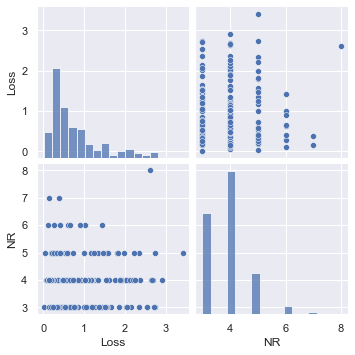

In [17]:
sns.pairplot(df)

<AxesSubplot:>

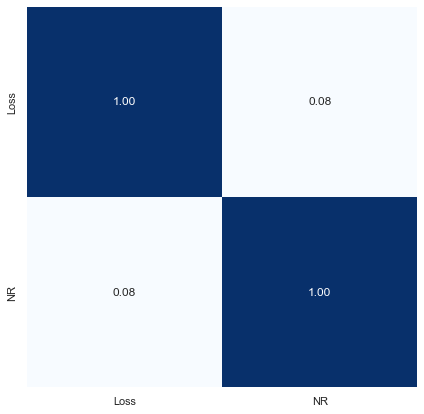

In [18]:
plt.figure(figsize=(7, 7))
corr = np.corrcoef(df.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df.columns, yticklabels=df.columns)

Hierarchical clustering (tree clustering - dendrogram)

In [19]:
# Leaving only the Loss column to perform cluster analysis
df = df.drop('NR', 1) 
#df = df.drop('Loss', 1)

In [20]:
df_scaled = df.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df)

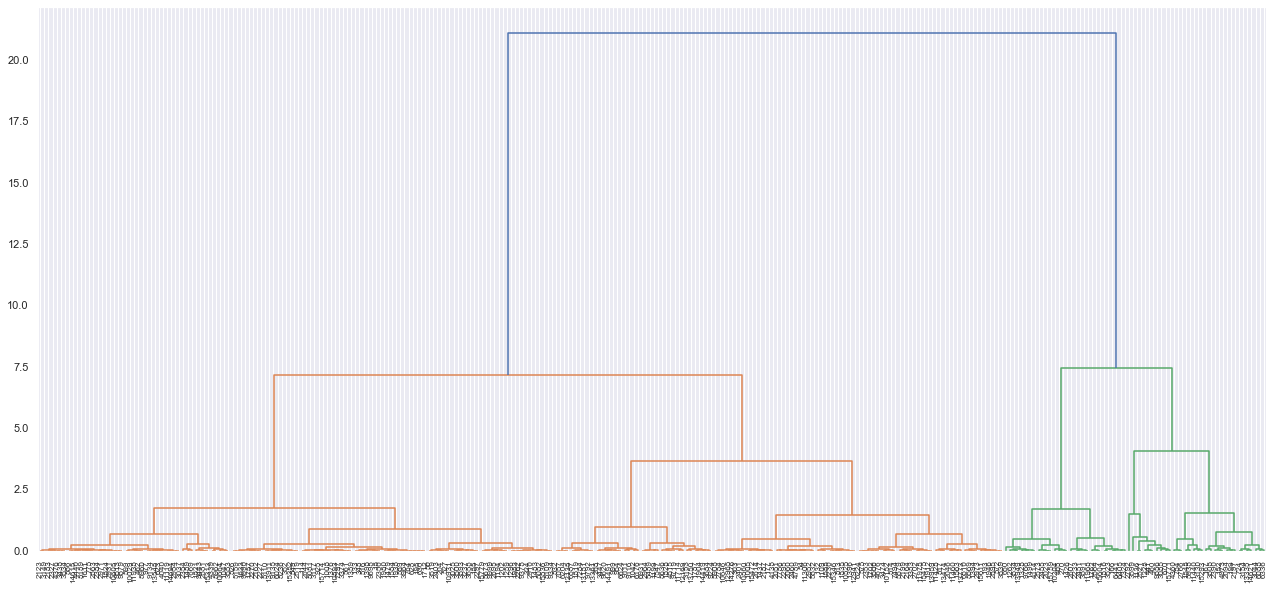

In [21]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [22]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
df_scaled['cluster_agglomerative'] = cluster.fit_predict(df_scaled)

In [23]:
# descriptive statistics of groups
df_groups = df.copy()
df_groups["cluster_agglomerative"] = cluster.labels_
df_groups = df_groups.groupby("cluster_agglomerative")
df_groups.describe()

Loss                                          \
                       count      mean       std       min       25%   
cluster_agglomerative                                                  
0                      236.0  0.483735  0.260380  0.012553  0.280332   
1                       34.0  2.273992  0.385293  1.760334  1.994485   
2                       30.0  1.405532  0.162292  1.158460  1.246225   

                                                     
                            50%       75%       max  
cluster_agglomerative                                
0                      0.416058  0.645195  1.091445  
1                      2.170452  2.587045  3.412221  
2                      1.434622  1.548282  1.655438

In [24]:

users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [18, 50, 54, 114, 132, 133, 177, 185, 193, 195, 204, 208, 303, 324, 348, 352, 462, 516, 527, 549, 561, 572, 575, 589, 599, 623, 628, 630, 764, 775, 813, 814, 817, 826, 832, 886, 925, 954, 977, 999, 1005, 1008, 1042, 1047, 1109, 1194, 1199, 1202, 1259, 1296, 1359, 1376, 1394, 1396, 1398, 1437, 1479, 1483, 1489, 1563, 1584, 1588, 1611, 1633, 1702, 1712, 1757, 1787, 1819, 1821, 1824, 1828, 1835, 1904, 1912, 1938, 1946, 1980, 1983, 2046, 2051, 2060, 2123, 2162, 2164, 2183, 2187, 2199, 2227, 2230, 2262, 2270, 2295, 2297, 2327, 2350, 2353, 2354, 2384, 2401, 2403, 2460, 2519, 2614, 2644, 2695, 2702, 2784, 2863, 2881, 2895, 2910, 2931, 2952, 2954, 2964, 2971, 2973, 3025, 3037, 3117, 3149, 3153, 3237, 3374, 3383, 3438, 3447, 3474, 3500, 3506, 3519, 3534, 3553, 3658, 3684, 3839, 3893, 3964, 4040, 4138, 4339, 4376, 4440, 4515, 4676, 4789, 5082, 5110, 5159, 5489, 5579, 5673, 5832, 5908, 6024, 6176, 6204, 6224, 6587, 6624, 6810, 6931, 7057, 7284, 7297, 7494, 7547, 7669, 7786, 8081, 8109,

Non-hierarchical grouping (K-means)

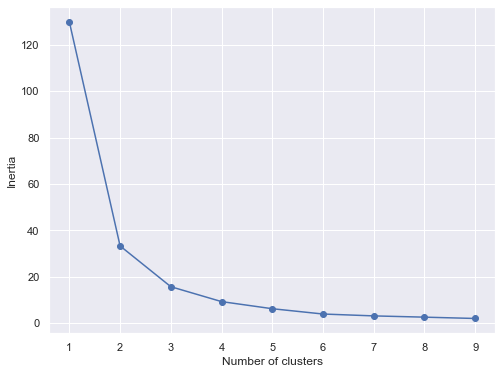

In [25]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

# plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [26]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster_kmeans'] = kmeans.fit_predict(df_scaled)

In [27]:
df_scaled

,Loss,cluster_agglomerative,cluster_kmeans
18,-0.709947,0,1
50,-0.647954,0,1
54,-0.389051,0,1
114,-0.691380,0,1
132,-0.349481,0,1
...,...,...,...
15714,-0.687661,0,1
15759,1.137056,2,0
15771,2.854081,1,2
15779,-0.519027,0,1


In [28]:
users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [18, 50, 54, 114, 132, 133, 177, 185, 193, 195, 204, 208, 303, 324, 348, 352, 462, 516, 527, 549, 561, 572, 575, 589, 599, 623, 628, 630, 764, 775, 813, 814, 817, 826, 832, 886, 925, 954, 977, 999, 1005, 1008, 1042, 1047, 1109, 1194, 1199, 1202, 1259, 1296, 1359, 1376, 1394, 1396, 1398, 1437, 1479, 1483, 1489, 1563, 1584, 1588, 1611, 1633, 1702, 1712, 1757, 1787, 1819, 1821, 1824, 1828, 1835, 1904, 1912, 1938, 1946, 1980, 1983, 2046, 2051, 2060, 2123, 2162, 2164, 2183, 2187, 2199, 2227, 2230, 2262, 2270, 2295, 2297, 2327, 2350, 2353, 2354, 2384, 2401, 2403, 2460, 2519, 2614, 2644, 2695, 2702, 2784, 2863, 2881, 2895, 2910, 2931, 2952, 2954, 2964, 2971, 2973, 3025, 3037, 3117, 3149, 3153, 3237, 3374, 3383, 3438, 3447, 3474, 3500, 3506, 3519, 3534, 3553, 3658, 3684, 3839, 3893, 3964, 4040, 4138, 4339, 4376, 4440, 4515, 4676, 4789, 5082, 5110, 5159, 5489, 5579, 5673, 5832, 5908, 6024, 6176, 6204, 6224, 6587, 6624, 6810, 6931, 7057, 7284, 7297, 7494, 7547, 7669, 7786, 8081, 8109,

In [29]:
# clustering performance evaluation
from sklearn.metrics import davies_bouldin_score
print('davies_bouldin_score: ', davies_bouldin_score(df_scaled, kmeans.labels_))

from sklearn.metrics import silhouette_score
print('silhouette_score: ', silhouette_score(df_scaled, kmeans.labels_, metric='euclidean'))

davies_bouldin_score:  0.2683795970240595
silhouette_score:  0.827343002675996


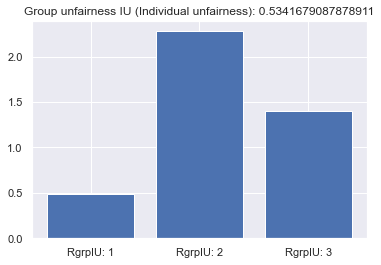

In [30]:
# G group: identifying the groups (IU: individual unfairness - the variance of the user losses)
# The configuration of groups was based in the hierarchical clustering (tree clustering - dendrogram)
# Clusters 1, 2 and 3
G = {1: [18, 50, 54, 114, 132, 133, 177, 185, 193, 195, 204, 208, 303, 324, 348, 352, 462, 516, 527, 549, 561, 572, 575, 589, 599, 623, 628, 630, 764, 775, 813, 814, 817, 826, 832, 886, 925, 954, 977, 999, 1005, 1008, 1042, 1047, 1109, 1194, 1199, 1202, 1259, 1296, 1359, 1376, 1394, 1396, 1398, 1437, 1479, 1483, 1489, 1563, 1584, 1588, 1611, 1633, 1702, 1712, 1757, 1787, 1819, 1821, 1824, 1828, 1835, 1904, 1912, 1938, 1946, 1980, 1983, 2046, 2051, 2060, 2123, 2162, 2164, 2183, 2187, 2199, 2227, 2230, 2262, 2270, 2295, 2297, 2327, 2350, 2353, 2354, 2384, 2401, 2403, 2460, 2519, 2614, 2644, 2695, 2702, 2784, 2863, 2881, 2895, 2910, 2931, 2952, 2954, 2964, 2971, 2973, 3025, 3037, 3117, 3149, 3153, 3237, 3374, 3383, 3438, 3447, 3474, 3500, 3506, 3519, 3534, 3553, 3658, 3684, 3839, 3893, 3964, 4040, 4138, 4339, 4376, 4440, 4515, 4676, 4789, 5082, 5110, 5159, 5489, 5579, 5673, 5832, 5908, 6024, 6176, 6204, 6224, 6587, 6624, 6810, 6931, 7057, 7284, 7297, 7494, 7547, 7669, 7786, 8081, 8109, 8189, 8236, 8569, 8636, 8960, 8962, 9111, 9116, 9134, 9135, 9224, 9334, 9378, 9443, 9513, 9620, 9698, 9719, 9792, 9879, 9990, 9999, 10029, 10152, 10525, 10605, 10646, 10664, 10860, 10893, 10931, 11119, 11306, 11428, 11460, 11714, 11938, 11978, 12138, 12169, 12941, 12965, 13181, 13361, 13474, 13548, 13750, 13773, 13911, 13959, 14276, 14419, 14491, 14615, 14694, 15313, 15346, 15352, 15472, 15475, 15611, 15714, 15779, 15836], 2: [152, 167, 199, 441, 460, 670, 724, 784, 1136, 1228, 1548, 2094, 2197, 2390, 2521, 2766, 2792, 3044, 3085, 3130, 3154, 3599, 3808, 4360, 4973, 5938, 6088, 6336, 9856, 11440, 13335, 14621, 15293, 15771], 3: [166, 270, 405, 650, 1262, 1328, 1426, 1499, 1762, 1816, 2023, 2233, 2451, 2455, 2573, 2607, 2864, 3523, 3834, 3891, 4114, 6405, 6441, 7324, 9766, 10204, 11968, 13949, 15604, 15759]}

glv = GroupLossVariance(X, omega, G, 1) #axis = 1 (0 rows e 1 columns)
losses_RgrpIU = glv.get_losses(X_est)
RgrpIU = glv.evaluate(X_est)

RgrpIU_groups = ['RgrpIU: 1', 'RgrpIU: 2', 'RgrpIU: 3']
plt.bar(RgrpIU_groups, losses_RgrpIU)
plt.title('Group unfairness IU (Individual unfairness): ' +  str(RgrpIU))
plt.show()